# Noise Mitigation on 1-bit Teleportation:

## Circuit:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools import visualization as qplt

import NoisyQuantumCircuit as NoisyQuantumCircuit

In [2]:
from qiskit import Aer
import qiskit.providers.aer as aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

In [3]:
# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel

# Import all standard errors
from qiskit.providers.aer.noise.errors import *  

# Import noise base clases
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError
from qiskit.providers.aer.noise.errors.readout_error import ReadoutError

# Import Complex math + random numbers
import random
from cmath import *

In [4]:
def get_random_state():
    theta = np.pi*random.random()
    phi = 2*np.pi*random.random()

    a = np.cos(theta/2)
    b = rect(1,phi)*np.sin(theta/2)
    
    return a, b, theta, phi

In [30]:
def CompileAndTeleport(errors1Qubit, errors2Qubit, nQubits = 2, numShots = 1024, debug = False):
    
    # Simulator, and constants
    qSimulator = QasmSimulator() 
    
    # System Specification
    qReg = QuantumRegister(nQubits)
    cReg = ClassicalRegister(nQubits)
    #qNoisyCirc = NoisyQuantumCircuit.NoisyQuantumCircuit(qReg, cReg, nQubits, errors1Qubit, errors2Qubit)
    
    qCirc = QuantumCircuit(qReg,cReg)
    
    # Initialize to a random initial state
    a0,b0, theta, phi = get_random_state()
    qCirc.u3(theta, phi, 0, qReg[0])
    
    # Teleportation Circuit
    qCirc.cx(qReg[0], qReg[1])
    qCirc.h(qReg[0])

    qCirc.barrier(qReg)
    qCirc.measure(qReg[0], cReg[0])

    qCirc.z(qReg[1]).c_if(cReg, 1)

    # Measure
    qCirc.measure(qReg[1], cReg[1])
    
    # Debug: Print the error model and plot the circuit
    if(debug):
        print("Errors: ")
        for errors in zip(errors1Qubit, errors2Qubit):
            print(errors)
        #print(qNoisyCirc.draw())
    
    # Execute the noisy simulation
    qNoisyCirc = NoisyQuantumCircuit.NoisyQuantumCircuit(qCirc, nQubits, errors1Qubit, errors2Qubit)
    result = qiskit.execute(qNoisyCirc.getQuantumCircuit(), qSimulator, shots=numShots, 
                           basis_gates = qNoisyCirc.getNoiseModel().basis_gates,
                           noise_model = qNoisyCirc.getNoiseModel()).result()
    counts = result.get_counts(0)

    if(debug):
        print(counts)
        
    
    # Return magnitudes of a0, b0 instead:
    mag_a0 = np.sqrt(a0*a0.conjugate()).real
    mag_b0 = np.sqrt(b0*b0.conjugate()).real
    
    return (counts, mag_a0, mag_b0)

## Try with one simulation - Thermal Relaxation T1 noise

Errors: 
(QuantumError([([{'name': 'kraus', 'qubits': [0], 'params': [array([[1.        , 0.        ],
       [0.        , 0.99739922]]), array([[0.        , 0.07207492],
       [0.        , 0.        ]])]}], 1)]), QuantumError([([{'name': 'kraus', 'qubits': [0, 1], 'params': [array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.99739922, 0.        , 0.        ],
       [0.        , 0.        , 0.99739922, 0.        ],
       [0.        , 0.        , 0.        , 0.99480521]]), array([[0.        , 0.        , 0.07207492, 0.        ],
       [0.        , 0.        , 0.        , 0.07188746],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]]), array([[0.        , 0.07207492, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.07188746],
       [0.        , 0.        , 0.        , 0.        ]]), array([[0.        , 0.        , 

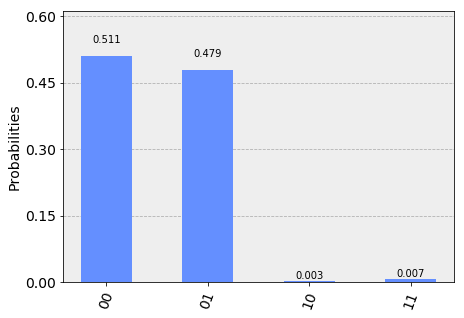

In [31]:
T1 = 12000  # nanoseconds
T2 = T1 * 2 # nanoseconds
Tau0 = 50   # nanoseconds    
pulseWidth = 1.25*Tau0

thermalError1bit = thermal_relaxation_error(T1, T2, pulseWidth)
thermalError2bit = thermal_relaxation_error(T1, T2, pulseWidth).kron(
                    thermal_relaxation_error(T1, T2, pulseWidth))


return_list = CompileAndTeleport(debug = True, 
                            errors1Qubit = [thermalError1bit], errors2Qubit = [thermalError2bit])
counts = return_list[0]
mag_a0 = return_list[1]
mag_b0 = return_list[2]

print(counts)
qplt.plot_histogram(counts)

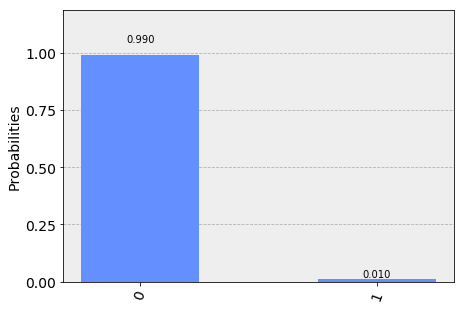

In [32]:
bob = {}
bob['0'] = counts['00'] + counts['01']
bob['1'] = counts['10'] + counts['11'] 
qplt.plot_histogram(bob)

In [33]:
a1 = np.sqrt(bob['0']/(bob['0']+bob['1']))
b1 = np.sqrt(bob['1']/(bob['0']+bob['1']))

print("Initial mag:", mag_a0, mag_b0)
print("Final amp:", a1, b1)

fidelity = ((mag_a0*a1) + (mag_b0*b1)).real

print("Fidelity:", fidelity)

Initial mag: 0.9960161225119198 0.08917333511941992
Final amp: 0.9951052080056662 0.09882117688026186
Fidelity: 0.9999530446920601


## Multiple Simulations

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

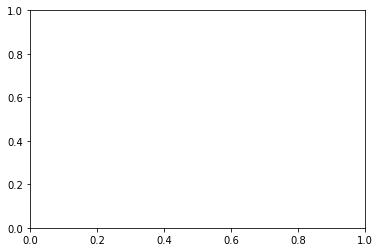

In [36]:
nPoints = 20
stretchFactors = [1, 1.25, 2, 3, 4, 5]
yAggregator = []
numShots = 4096

for sf in stretchFactors:
    y = []
        
    # Thermal Relaxation Error - T1
    T1 = 12000  # nanoseconds
    T2 = T1 * 2 # nanoseconds
    Tau0 = 50   # nanoseconds
    pulseWidth = sf * Tau0 

    thermalError1bit = thermal_relaxation_error(T1, T2, pulseWidth)
    thermalError2bit = thermal_relaxation_error(T1, T2, pulseWidth).kron(
                        thermal_relaxation_error(T1, T2, pulseWidth))

    return_list = CompileAndTeleport(numShots = numShots,
                                errors1Qubit = [thermalError1bit], errors2Qubit = [thermalError2bit])
    
    # What Bob measures: 
    bob = {}
    bob['0'] = counts['00'] + counts['01']
    bob['1'] = counts['10'] + counts['11'] 
    a1 = np.sqrt(bob['0']/(bob['0']+bob['1']))
    b1 = np.sqrt(bob['1']/(bob['0']+bob['1']))
    
    fidelity = ((mag_a0*a1) + (mag_b0*b1)).real

    y.append(fidelity)
    
    yAggregator.append(fidelity)

plt.plot(stretchFactors, y, label="stretch factor = {0}".format(sf))

plt.legend()
plt.show()

## Extrapolate to Maximize Noise Mitigation

In [ ]:
deg = 2

yFitted = []
errFitted = []

for j in range(nPoints):
    y = []
    for i in range(len(stretchFactors)):
        y.append(yAggregator[i][j])
        
    p, V = np.polyfit(stretchFactors, y, deg, cov = True)
    yFitted.append(np.max(p[deg], 0))
    errFitted.append(np.sqrt(V[deg][deg]))

for run in range(len(stretchFactors)):
    plt.plot(gatePairCounts, yAggregator[run], label="Stretch Factor = {0}".format(stretchFactors[run]))

plt.errorbar(gatePairCounts, yFitted, yerr=errFitted, label="Mitigated")

plt.legend()
plt.show()

# Other Errors:

### 1. Pauli Errors -- Doesn't work yet!

In [ ]:
# Generate Data
nPoints = 20
probailities = [0.001, 0.01, 0.05, 0.1, 0.15]
gatePairCounts = [x*10 for x in range(nPoints)]
yAggregator = []

for pb in probailities:
    y = []
    
    for gpc in gatePairCounts:
        
        # Thermal Relaxation Error - T1
        pauliErr = pauli_error([('X', pb), ('I', 1 - pb)])
        
        counts = CompileAndSimulate(gatePairCount = gpc, nQubits = 1, bitIdx = 0, 
                                    errors1Qubit = [pauliErr], errors2Qubit = [])
        
        if(counts["0"] == None): 
            p = 0
        else:
            p = counts["0"]/1024
            
        y.append(p)
    
    yAggregator.append(y)
    
# Extrapolate
deg = 2

yFitted = []
errFitted = []

for j in range(nPoints):
    y = []
    for i in range(len(probabilities)):
        y.append(yAggregator[i][j])
        
    p, V = np.polyfit(stretchFactors, y, deg, cov = True)
    yFitted.append(np.max(p[deg], 0))
    errFitted.append(np.sqrt(V[deg][deg]))

for run in range(len(stretchFactors)):
    plt.plot(gatePairCounts, yAggregator[run], label="Stretch Factor = {0}".format(stretchFactors[run]))

plt.errorbar(gatePairCounts, yFitted, yerr=errFitted, label="Mitigated")

plt.legend()
plt.show()    
    